In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
import sys
% matplotlib inline

In [2]:
fname = '200625//200625_Bi2Ye30617_3w_1.txt'
df = pd.read_csv(fname, sep = ' ')

In [34]:
alpha = 0.0048331#temperature coefficient --need remeasure for better accuracy
Re0 = 3.105#resistance at RT
Rref = 3
X1_ref = 0.0572512
I1w = X1_ref / Rref
l = 4e-3/2#half length of wire(= half gap width)
width = 2e-3; #mm line width --
thickness = 50e-6 #mm line thickness --
S = width * thickness  #crosssectional area
rou =  7.74e3#kg/m^3 density
#correction_factor = 1 - 1.5 / (50 + 2.7 + 3.5) # 1 - R_all_3w_parts / R_total

In [12]:
def X3_calc(f1, k, cp, correction_factor = 1):
    w1 = 2 * np.pi * f1
    kappa = k / (rou * cp)
    tau = 4 * l**2 / kappa
    X3 = - alpha * Re0**2 * I1w**3 * l / (12 * k * S) * (1 / (1 + (w1 * tau / 5)**2))
    return X3
def Y3_calc(f1, k, cp, correction_factor = 1):
    w1 = 2 * np.pi * f1
    kappa = k / (rou * cp)
    tau = 4 * l**2 / kappa
    Y3 = alpha * Re0**2 * I1w**3 * l / (12 * k * S) * ((w1 * tau / 5) / (1 + (w1 * tau / 5)**2))
    return Y3
def X3_Y3_fit(fcombo, k, cp):
    X3 = X3_calc(fcombo[:int(len(fcombo) / 2)], k, cp)
    Y3 = Y3_calc(fcombo[int(len(fcombo) / 2):], k, cp)
    return np.concatenate([X3,Y3])

In [35]:
xdata = np.concatenate([df['Lockin1f'], df['Lockin1f']])
ydata = np.concatenate([df['X3'], df['Y3']])
popt, pcov = curve_fit(X3_Y3_fit, xdata, ydata, p0 = [10, 10])

In [38]:
popt,pcov

(array([  4.45072804,  56.34909106]),
 array([[  3.26640917e-04,  -3.43099624e-12],
        [ -3.43099624e-12,   3.83092171e-01]]))

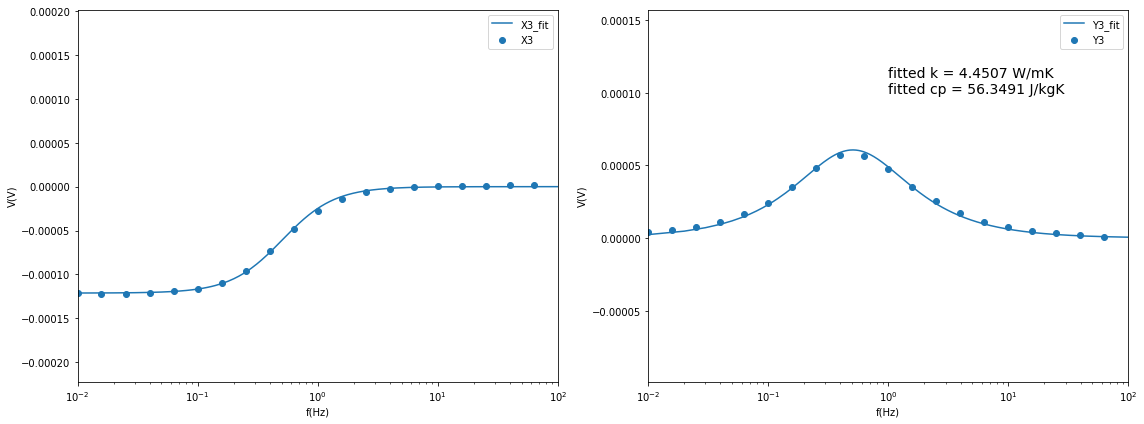

In [46]:
fig, axs = plt.subplots(1, 2, figsize = (16,6))

f1 = np.arange(0.01, 100.01, 0.01)

axs[0].scatter(df.Lockin1f, df.X3, label = 'X3')
axs[0].plot(f1, X3_calc(f1,*popt), label = 'X3_fit')
axs[0].set_xlabel('f(Hz)')
axs[0].set_ylabel('V(V)')
axs[0].set_xscale('log')
axs[0].set_xlim(0.01,100)
axs[0].legend(loc = 'upper right')
axs[0].set_ylim(df.X3.min() - 0.0001, df.X3.max() + 0.0002)

axs[1].scatter(df.Lockin1f, df.Y3, label = 'Y3')
axs[1].plot(f1, Y3_calc(f1, *popt), label = 'Y3_fit')
axs[1].set_xlabel('f(Hz)')
axs[1].set_ylabel('V(V)')
axs[1].set_xscale('log')
axs[1].set_xlim(0.01,100)
axs[1].legend(loc = 'upper right')
axs[1].set_ylim(df.Y3.min() - 0.0001, df.Y3.max() + 0.0001)
axs[1].text(1,0.0001, f"fitted k = {round(popt[0],4)} W/mK\nfitted cp = {round(popt[1],4)} J/kgK", fontsize = 14)

#plt.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.tight_layout()
fig.savefig(fname[:-4] + '_fitting.jpg', dpi = 300)

In [39]:
help(plt.text)

Help on function text in module matplotlib.pyplot:

text(x, y, s, fontdict=None, withdash=False, **kwargs)
    Add text to the axes.
    
    Add the text *s* to the axes at location *x*, *y* in data coordinates.
    
    Parameters
    ----------
    x, y : scalars
        The position to place the text. By default, this is in data
        coordinates. The coordinate system can be changed using the
        *transform* parameter.
    
    s : str
        The text.
    
    fontdict : dictionary, optional, default: None
        A dictionary to override the default text properties. If fontdict
        is None, the defaults are determined by your rc parameters.
    
    withdash : boolean, optional, default: False
        Creates a `~matplotlib.text.TextWithDash` instance instead of a
        `~matplotlib.text.Text` instance.
    
    Returns
    -------
    text : `.Text`
        The created `.Text` instance.
    
    Other Parameters
    ----------------
    **kwargs : `~matplotlib.text